# VISUAL STEREO ODOMETRY

### Introduction

<div style="text-align:justify">
Stereo odometry is a technique for estimating the motion of a camera, or a mobile robot equipped with cameras, by analyzing the images captured by two or more cameras placed at different positions. It is a form of visual odometry that uses stereo vision to estimate the relative pose between successive frames of the camera. <br>
</div>

### Algorithm Overview

<div style="text-align:justify">

In the following notebook, we will be using keypoint matches and depth maps to estimate odometry. Hence we will be using the 3D to 3D visual odometry algorithm shown below. <br>

<div style="text-align:center">
    <img src="Images/3d_to_3d_visual_odometry_algorithm.png" style="width: 75%; height: auto"/>
    <figcaption>3D to 3D Visual Odometry Algorithm</figcaption>
</div>

In this algorithm the 3D point coordinates of corresponding keypoints in two camera frames are assumed to be known (achieved through getting a depth map using Semi Global Matching algorithm ). We use this to determine the relative camera pose in the current time step with respect to the previous time step. 

We basically determine the rigid transformation that aligns two sets of 3D points by minimiizing the geometric least squares error. A closed form solution is available for this method. 

Link to Paper (Arun et al. 1987) : [Link](https://ieeexplore.ieee.org/document/4767965)
 
</div>

### Dataset

Link to KITTI Visual Odometry Dataset : [Link](https://www.cvlibs.net/datasets/kitti/eval_odometry.php)

For this project only the following datasets would be needed: 

1. odometry_data_set (grayscale , 22GB)
2. odometry_data_set (calibration_files , 1MB)
3. odometry_ground_truth_poses (4MB)
4. odometry_data_set (velodyne_laser_data .80 GB) --- OPTIONAL

**Note 1 :** We would be using the LIDAR data from the velodyne_laser_data set to compare the depths obtained from the stereo images vs lidar point clouds

**Note 2** Change the file paths based on your system to link the code to your dataset directory.  


### Sensor Setup
Link to details on the Sensor Setup : [Link](https://www.cvlibs.net/datasets/kitti/setup.php)


A reference picture of the sensor setup is shown below: 
<div style="text-align:center">
    <img src="Images/sensor_setup.png" style="width: 75%; height: auto"/>
</div>




In [268]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### Extract Ground Truth Trajectory for Sequence 1

In [269]:
gt_poses_raw = pd.read_csv('./dataset/data_odometry_poses/dataset/poses/00.txt' , delimiter=' ', header = None)
print("Shape of ground truth dataframe: " , gt_poses_raw.shape)
gt_poses_raw.head()

Shape of ground truth dataframe:  (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


The ground truth data (sequence 1) has 4541 rows corresponding to the number of image frames and 12 columns corresponding to the flattened 3x4 transformation matrix of the left stereo camera with respect to the global coordinate frame. 

The 3x4 transformation matrix contains a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector (R|t)

We can see this below

In [270]:
print('Starting position:')
start_pose = np.array(gt_poses_raw.iloc[0]).reshape((3,4)).round(2)
start_pose

Starting position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

As this is the start position, the rotation matrix is an identity matrix and the translation vector is a zero vector. 

Similarly the [R|t] transformation matrix can be used to represent the transformation between the current camera coordinate and the world coordinate frame. the world coordinate frame has been taken as the initial position of the camera. 

We now store the ground truth poses in a 3D numpy array 

In [271]:
gt_poses = np.zeros((len(gt_poses_raw),3,4))
for i in range(len(gt_poses_raw)):
    gt_poses[i] = np.array(gt_poses_raw.iloc[i]).reshape((3,4))

In [272]:
gt_poses[0]

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16]])

During the course of this program , we dont need to be concerned with the rotation matrix as the camera rotation effects are implicit in the position of the camera origin over time.

We can extract the position of the camera (t) from the transformation matrix [R|t] in the following way

In [273]:
gt_poses[1].dot(np.array([0,0,0,1]))

array([-0.04690294, -0.02839928,  0.8586941 ])

Here we see at the second time step , the value of z coordinate is positive , which means the car has moved forward. (The Z axis of the camera in the camera frame points outward)

In [274]:
%matplotlib inline

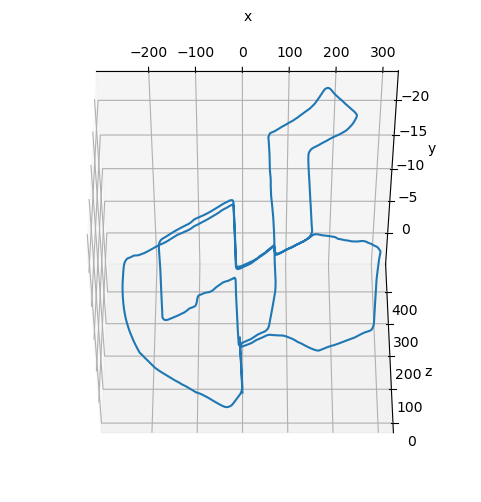

In [275]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt_poses[:, :, 3][:, 0], gt_poses[:, :, 3][:, 1], gt_poses[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

Here we see that the trajectory starts and ends at the same position. Also there seems to be a slight inclination along the y axis during the trajectory indicating the car may have traversed through a hill. 

Test image

In [276]:
test_image = cv2.imread("./dataset/data_odometry_gray/dataset/sequences/00/image_0/000000.png")

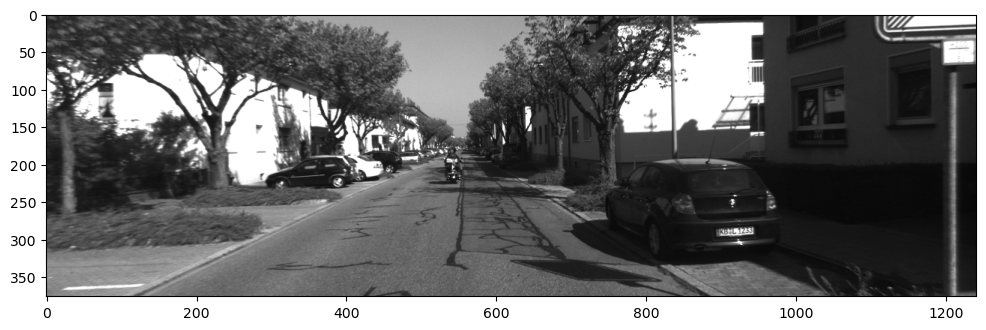

In [277]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.imshow(test_image)

Here we see the initial image from the grayscale camera (left). This is indicated as 000000.png in image 0 in sequence 0. 

Camera Calibration

In [278]:
calib_data = pd.read_csv("./dataset/data_odometry_calib/dataset/sequences/00/calib.txt", delimiter= ' ', header =  None , index_col=0)
calib_data

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


**Note**: If you do not see the 5th row in the dataframe labeled 'Tr' then the calibration file is incorrect. Please download the following calibration file from this link : [calibration_data](https://www.cvlibs.net/download.php?file=data_odometry_calib.zip) 

The txt file gives us the projection matrices of 4 cameras that have been mounted on the vehicle. P0 and P1 are the left and right grey scale cameras. P2 and P3 are the left and right color cameras. 

the projection matrix for each camera has been flattened out and can be reshaped and extracted. The Tr row is the transformation matrix data for the LIDAR. 

In [279]:
#Extracted Projection matrix for left grey camera
P0 = np.array(calib_data.loc['P0:']).reshape(3,4)
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

**NOTE:** The projection matrix for a camera from the calibration file is **after rectification** with respect to the stereo camera setup.

Usually the projection matrix of a camera takes a 3D point in the global coordinate frame and projects it into the pixel coordinates of that camera,s image frame.

Rectified projection matrix transforms 3D points from a world coordinate system to a rectified image coordinate system. They map points from each camera's coordinate frame onto the coordinate frame of a single image plane. In this case that would be the left camera. 

The rectified projection matrix is used in stereo vision applications to rectify the stereo image pair such that the corresponding epipolar lines are aligned horizontally. This simplifies the task of computing disparities between the stereo images and improves the accuracy of the stereo matching algorithm.



In [280]:
#Decomposition of projection matrix of right greyscale camera

P1 = np.array(calib_data.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix cam 1:' )
print(k1 ,"\n" )
print('Rotation Matrix cam 1:')
print(r1,"\n")
print('Translation Vector cam 1:')
print(t1.round(4),"\n")

#Decomposition of projection matrix of the left greyscale camera

P0 = np.array(calib_data.loc['P0:']).reshape((3,4))
k0, r0, t0, _, _, _, _ = cv2.decomposeProjectionMatrix(P0)
t0 = t0 / t0[3]
print('Intrinsic Matrix cam 0:')
print(k0 ,"\n")
print('Rotation Matrix cam 0:')
print(r0 ,"\n")
print('Translation Vector cam 0:')
print(t0.round(4), "\n")

Intrinsic Matrix cam 1:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

Rotation Matrix cam 1:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Translation Vector cam 1:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]] 

Intrinsic Matrix cam 0:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

Rotation Matrix cam 0:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Translation Vector cam 0:
[[0.]
 [0.]
 [0.]
 [1.]] 



In [281]:
# Get the rotation and translation vector of right camera in the form [R|t]
Rt_cam1 = np.hstack([r1,t1[:3]]).round(4)
print("Transformation Matrix Camera 1")
print(Rt_cam1,"\n")
#Extract translation vector 
print("Translation vector Camera 1")
origin = np.array([0,0,0,1])
Rt_cam1.dot(origin).round(4).reshape(-1,1)

Transformation Matrix Camera 1
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]] 

Translation vector Camera 1


array([[0.5372],
       [0.    ],
       [0.    ]])

The positive value (+0.54) in the translation vector of the right camera shows that the world coordinate is the left camera. 


### Dataset Handler

<div style="text-align:justify">

A dataset handler will make the data from our dataset more accesible. If all the images in the dataset are loaded at once into a list and then accessed, it would take up too much space in the RAM. Instead, using a generator with a buffer of 1 we can access the image file from the directory one after the other using the custom dataset handler. We need a buffer of 1 as we would want to compare the image pair at timestep t to the pair at t-1 .  

**Note:** If the LIDAR data is used, it is important to tell numpy to decode the velodyne binaries as float32 as by default it decodes to float64 and thus the decoded information would be incorrect. 

</div>

In [282]:
sensor_data = Dataset_Handler('00')

### Disparity Map

<div style="text-align:justify">

In order to generate the depth map using a stereo camera , we need three parameters: 
* Focal length of the cameras (f)
* Baseline between cameras (b)
* Disparity in poxel value(d)

$$d = x_{l} - x_{r}$$

here $x_{l}$ and $x_{r}$ are the differences in horizontal pixel location of the point projected onto the left and right image planes

The equation to get the depth of a pixel in the picture is as follows: 

$$Z = \frac{fb}{d}$$


the focal length and the baseline are parameters of the camers. We can get the disparity map of the image using stereo matching. Algorithms such as StereoBM and StereoSGBM are widely used for this purpose. StereoSGBM gives better results thaan StereoBM.The main reason for this is that StereoSGBM uses a more advanced matching algorithm than StereoBM. 

**StereoBM** uses a simple block matching algorithm, which works by comparing pixels in a local window between the left and right images. However, this approach can fail in regions with textureless or repetitive patterns, resulting in incorrect depth estimates.

**StereoSGBM**, on the other hand, uses a more sophisticated semi-global matching algorithm that takes into account not only local pixel similarities but also the smoothness of the disparity map. It uses multiple paths to find the best match and combines the results to obtain a more robust disparity map. As a result, StereoSGBM is more effective in handling challenging scenes with textureless or repetitive patterns, producing more accurate depth maps than StereoBM. However, this comes at the cost of higher computational complexity and longer processing time.

</div>


    

In [283]:
def compute_left_disparity_map(left_image , right_image , match_algo = 'bm' , rgb = False , verbose = False):

    '''
    This function takes the image pair from the left and right cameras and computes the disparity map for the left image. 

    Argument Description: 

    left_image -- image obtained from the left camera
    right_image -- image obtained from the right camera

    Optional Arguments: 

    match_algo -- (str) -- 'bm' to use StereoBM or 'sgbm' to use StereoSGBM matching
    rgb -- (bool) -- True if the inputs are RGB
    verbose --(bool) -- True to report matching type and computation time

    Returns:
    disparity_left -- disparity map for the left camera image

    
    '''

    sad_window = 6 # sum of absolute differences window
    num_disp =  sad_window*16
    block_size = 11

    if match_algo == 'bm':

        matcher = cv2.StereoBM_create(numDisparities=num_disp , blockSize= block_size)

    elif match_algo == 'sgbm':
        
        matcher = cv2.StereoSGBM_create(numDisparities=num_disp, 
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8*3*sad_window**2,
                                        P2 = 32*3*sad_window**2,
                                        mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                        )
        
    if rgb:
        left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
        right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

    start = datetime.datetime.now()
    disparity_left = matcher.compute(left_image, right_image).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{match_algo.upper()}:', end-start)
    
    return disparity_left
        


In [284]:
%matplotlib inline

Time to compute disparity map using StereoBM: 0:00:00.026018


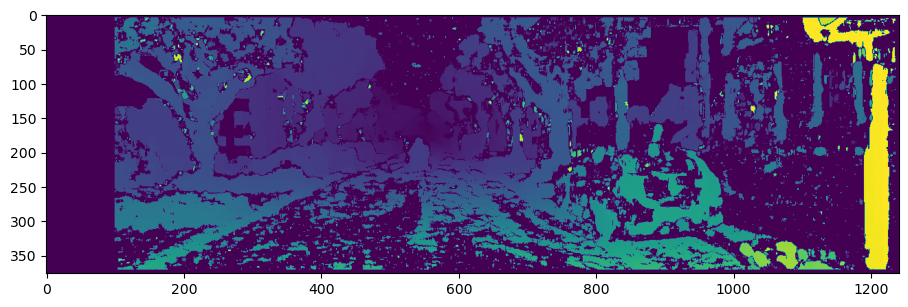

In [285]:
## Disparity map using StereoBM

disp = compute_left_disparity_map(sensor_data.first_image_left, 
                                  sensor_data.first_image_right, 
                                  match_algo='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

Time to compute disparity map using StereoSGBM: 0:00:00.080425


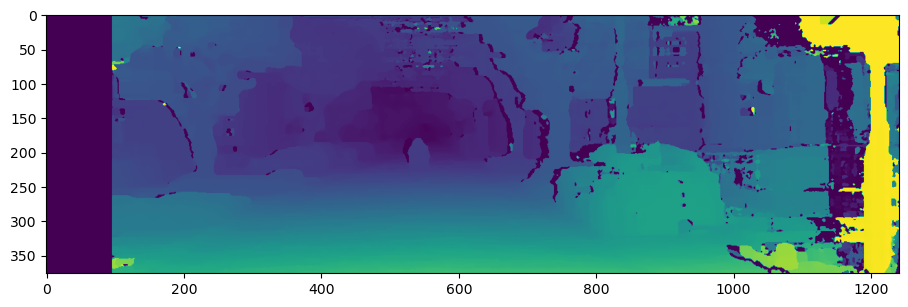

In [286]:
# Disparity map using StereoSGBM

disp = compute_left_disparity_map(sensor_data.first_image_left, 
                                  sensor_data.first_image_right, 
                                  match_algo='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)


<div style="text-align:justify">
We see that the Stereo SGBM algorithm takes around 3x longer but produces a much better disparity map with less information gaps. 

We also see that there is a gap on the left side of the image where the right camera did not have matching information. This means we can apply a mask when looking for features to match from one frame to the next so that we can use features which will fall in the area of the picture for which we have depth information. 

We can clearly see that there is a blindspot in the right camera in the images below
</div>

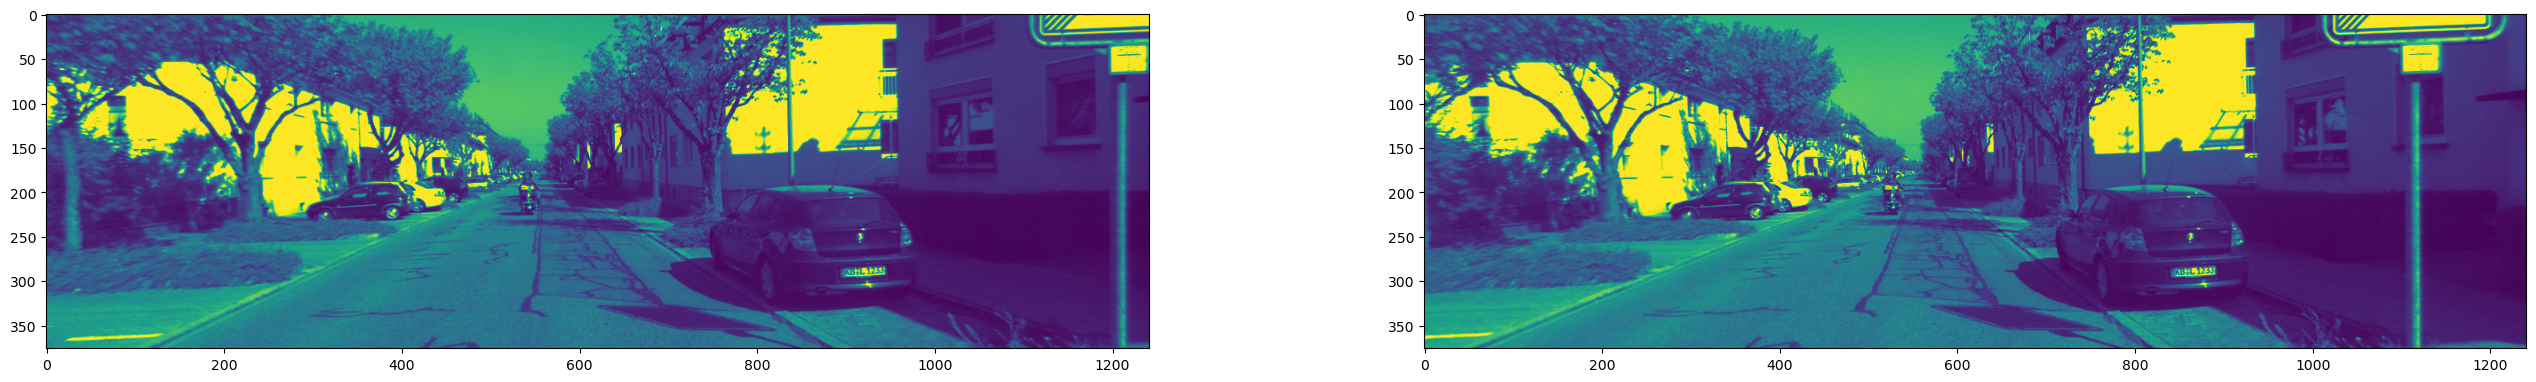

In [287]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.25)
fig.set_size_inches(32, 16)

ax1.imshow(sensor_data.first_image_left)
ax2.imshow(sensor_data.first_image_right)

plt.show()

In [288]:
type(sensor_data.first_image_left)

numpy.ndarray

In [289]:
disp[0,0]

-1.0

We see that the function places a -1.0 value wherever it gets improper or missing data

### Depth Map 

<div style="text-align:justify">

Now that we have a function to calculate the disparity map , we can proceed with the calculation of the depth map. First we would need to decompose the projection matrix to obtain the intrinsic and extrinsic camera parameters.

Once we have extracted the focal length and the base line values , we can proceed with the calculation of depth


</div>


In [290]:
def decompose_projection_matrix(p):

    k, r, t, _,_,_,_ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [291]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [292]:
k_left, r_left, t_left = decompose_projection_matrix(sensor_data.P0)
k_right, r_right, t_right = decompose_projection_matrix(sensor_data.P1)

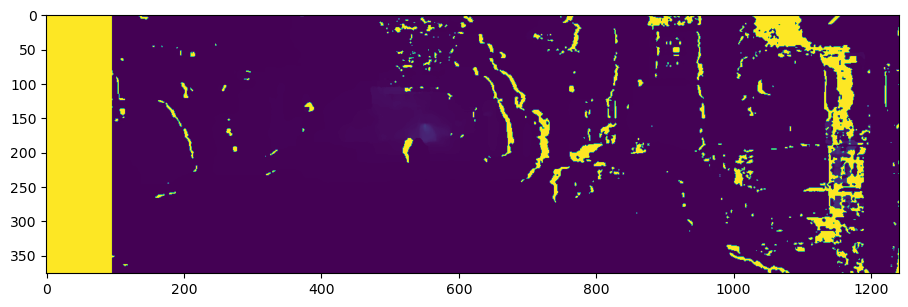

In [293]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth)

In [294]:
depth[0,0] == depth.max()

True

We see that the depth in the yellow band to the left is the same as the maximum depth. This is the result of the calculations of depth using 0 or -1.0 as the disparity value from the previous step. 

We do not want any features from found at this depth to enter our calculations. We can create a mask to prevent a feature detector from searching this area for features in every frame. 

In [295]:
def stereo_to_depth(left_image , right_image , P0 , P1 , matcher = 'bm' , rgb=False , verbose = False, rectified = True ):

    #Compute Disparity Map
    disp_map = compute_left_disparity_map(left_image , 
                                          right_image ,
                                            match_algo = matcher , 
                                            rgb=rgb , 
                                            verbose=verbose)

    # Decompose Projection Matrix
    k_left , r_left , t_left = decompose_projection_matrix(P0)
    k_right , r_right , t_right = decompose_projection_matrix(P1)

    # Calculate depth map of left camera image
    depth_map = calc_depth_map(disp , k_left , t_left , t_right)

    return depth_map

### Feature Matching

<div style="text-align:justify">

Now that we have a way to achieve our stereo depth estimates, we can proceed to finding features and matching them between the two images. 

The [Scale-Invariant Feature Transform](https://people.eecs.berkeley.edu/~malik/cs294/lowe-ijcv04.pdf) (SIFT) detector is a computer vision algorithm used for feature detection and extraction. It was developed by David Lowe in 1999 and is widely used in various applications, such as object recognition, image stitching, and visual odometry.

The SIFT detector works by identifying scale-invariant keypoints in an image. These keypoints are detected by analyzing the local intensity extrema in a scale-space representation of the image. The scale-space representation is obtained by convolving the image with Gaussian kernels at different scales, and then computing the difference of Gaussian (DoG) between successive scales. This DoG representation is used to detect keypoints that are stable across different scales.

Once keypoints are identified, the SIFT algorithm computes a local descriptor for each keypoint. The descriptor is a vector that captures the local gradient orientation and magnitude of the pixels surrounding the keypoint. The descriptor is invariant to rotation, translation, and scaling, making it robust to changes in the viewpoint of the object.

The SIFT detector has several advantages over other feature detectors. It is robust to image noise, illumination changes, and partial occlusions. It can detect multiple keypoints in an image, making it suitable for object recognition and tracking. The SIFT algorithm has become a standard feature detector in computer vision due to its high accuracy and robustness.


</div>

In [296]:
def extract_features(image , detector_algo = 'sift' , mask = None): 
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a greyscale image

    Returns:
    keypoint -- list of the extracted keypoints (features) in an image
    descriptor -- list of the keypoint descriptors in an image
    """
    if detector_algo == 'sift':
        det = cv2.SIFT_create()
    elif detector_algo == 'orb':
        det = cv2.ORB_create()
    elif detector_algo == 'surf':
        det = cv2.xfeatures2d.SURF_create()
    else : print("Please enter the correct feature extraction algorithm")
        
    keypoints, descriptors = det.detectAndCompute(image, mask)
    
    return keypoints, descriptors

<div style="text-align:justify">

Here we implement two different options for matching algorithms: 

* **Brute Force Matching (BF)**: BF matching is a straightforward approach where each descriptor in one image is compared to every descriptor in the other image. This can be very time-consuming when there are a large number of descriptors. BF matching is used when the number of features is relatively small or when high accuracy is required.

* **Fast Library for Approximate Nearest Neighbours (FLANN)**: FLANN (Fast Library for Approximate Nearest Neighbors) is a popular algorithm for matching keypoints in computer vision. It is a method for finding approximate nearest neighbors in high-dimensional spaces quickly and efficiently.The FLANN algorithm builds an index of the descriptors from one image and uses it to search for approximate nearest neighbors in the descriptors from the second image. The algorithm is based on a hierarchical clustering approach, which organizes the descriptors into a tree structure that is optimized for search speed.FLANN is typically faster than brute-force matching algorithms such as BFMatcher, but may not be as accurate in finding exact matches.

</div>

In [297]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)

        
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches


### Distance Ratios
A ratio test is used to determine the level of distinctiveness of features. This test involves finding the two nearest neighbors in the second image to the descriptor of each feature in the first, then using the ratio of their distances from their matched feature to see whether the distance between that feature's descriptor and its closest match is significantly different than the distance to its second closest match. If it is not, then this implies that the feature is not highly distinct, since it is roughly equally similar to at least two features in the second image, and should therefore not be used for photogrammetric reconstruction of motion.


In [298]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [299]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """

    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Number of matches before filtering: 3206
Number of matches after filtering: 446


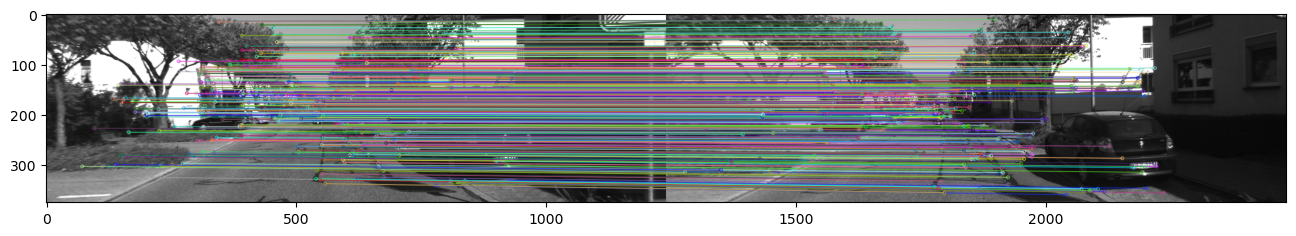

In [300]:
#Check SIFT Features 
image_left = sensor_data.first_image_left
image_right = sensor_data.first_image_right
image_plus1 = sensor_data.second_image_left

kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Number of matches before filtering: 500
Number of matches after filtering: 260


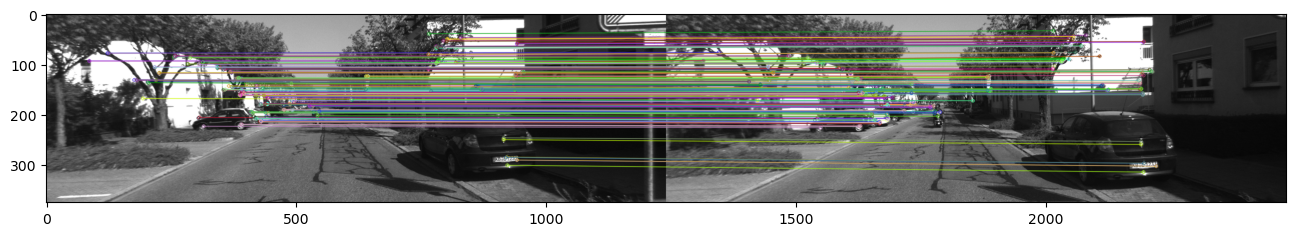

In [301]:
#Check orb features
image_left = sensor_data.first_image_left
image_right = sensor_data.first_image_right
image_plus1 = sensor_data.second_image_left

kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.8)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)